In [24]:
from clip_retrieval.clip_client import ClipClient, Modality
import clip  # pylint: disable=import-outside-toplevel
import torch
import time
import glob
from PIL import Image
import numpy as np

# Create numpy file

In [11]:
device = "cuda"
model, preprocess = clip.load("ViT-L/14", device=device, jit=True)

def time_complexity(func):
    def warp(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        print('Time inference: {} second'.format(time.time() - start))
        return result
    return warp
    
@time_complexity
def get_text_emb(text):
    with torch.no_grad():
        text_emb = model.encode_text(clip.tokenize([text], truncate=True).to(device))
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb.cpu().detach().numpy().astype("float32")[0]
    return text_emb

from PIL import Image as pimage

def get_image_emb(image_url):
    with torch.no_grad():
        image = pimage.open(image_url)
        image_emb = model.encode_image(preprocess(image).unsqueeze(0).to(device))
        image_emb /= image_emb.norm(dim=-1, keepdim=True)
        image_emb = image_emb.cpu().detach().numpy().astype("float32")[0]
        return image_emb

In [21]:
url = "a man with a girl"

red_tshirt_text_emb =  get_text_emb(url)


print(red_tshirt_text_emb.shape)

Time inference: 0.04942750930786133 second
(512,)


In [28]:
des_path =  "data/CLIPRetrival_Features"
paths = "data/KeyFramesC00_V00/"

video_paths = sorted(glob.glob(f"{paths}/*/"))
video_paths = ['/'.join(i.split('/')[:-1]) for i in video_paths]

# os.makedirs(des_path, exist_ok=True)

import time
start_time = time.time()

flag = 0
for vd_path in video_paths:
  print(vd_path)


  re_feats = []
  keyframe_paths = glob.glob(f'{vd_path}/*.jpg')
  keyframe_paths = sorted(keyframe_paths, key=lambda x : x.split('/')[-1].replace('.jpg',''))

  for keyframe_path in keyframe_paths:
    # image = preprocess(Image.open(keyframe_path)).unsqueeze(0).to(device)    

    image_feats = get_image_emb(keyframe_path)
    
    if flag == 0:
      #  print("Image feat: ", image_feats.shape)
       flag = 1

    re_feats.append(image_feats)

  name_npy = vd_path.split('/')[-1]
  outfile = f'{des_path}/{name_npy}.npy'
  np.save(outfile, re_feats)

print ("Time to extract image features and export npy . file by CLIP: ", time.time() - start_time) 

data/KeyFramesC00_V00/C00_V0000
data/KeyFramesC00_V00/C00_V0001
Time to extract image features and export npy . file by CLIP:  1542.281317949295


# Create file bin

In [1]:
import numpy as np
import faiss
import glob
import json
import matplotlib.pyplot as plt
import os
import math
import torch
import pandas as pd
import re
import clip
import time

from langdetect import detect

/home/toonies/anaconda3/envs/UTE-AI/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class File4Faiss:
  def __init__(self, root_database: str):
    self.root_database = root_database

  def re_shot_list(self, shot_list, id, k):
    len_lst = len(shot_list)
    if k>=len_lst or k == 0:
      return shot_list

    shot_list.sort()
    index_a = shot_list.index(id)

    index_get_right = k // 2
    index_get_left = k - index_get_right

    if index_a - index_get_left < 0:
      index_get_left = index_a
      index_get_right = k - index_a
    elif index_a + index_get_right >= len_lst:
      index_get_right = len_lst - index_a - 1
      index_get_left = k - index_get_right

    output = shot_list[index_a - index_get_left: index_a] + shot_list[index_a: index_a + index_get_right + 1]
    return output

  def write_json_file(self, json_path: str, shot_frames_path: str, option='full'):
    count = 0
    self.infos = []
    des_path = os.path.join(json_path, "keyframes_id.json")
    keyframe_paths = sorted(glob.glob(f'{self.root_database}/KeyFramesC0*'))

    for kf in keyframe_paths:
      video_paths = sorted(glob.glob(f"{kf}/*"))

      for video_path in video_paths:
        image_paths = sorted(glob.glob(f'{video_path}/*.jpg'))

        ###### Get all id keyframes from video_path ######
        id_keyframes = np.array([int(id.split('/')[-1].replace('.jpg', '')) for id in image_paths])

        ###### Get scenes from video_path ######
        video_info = video_path.split('/')[-1]
        
        with open(f'{shot_frames_path}/{video_info}.txt', 'r') as f:
          lst_range_shotes = f.readlines()
        lst_range_shotes = np.array([re.sub('\[|\]', '', line).strip().split(' ') for line in lst_range_shotes]).astype(np.uint32)

        for im_path in image_paths:
          # im_path = 'Database/' + '/'.join(im_path.split('/')[-3:])
          id = int(im_path.split('/')[-1].replace('.jpg', ''))
          
          i = 0
          flag=0
          for range_shot in lst_range_shotes:
            i+=1
            first, end = range_shot

            if first <= id <= end:
              break
            
            if i == len(lst_range_shotes):
              flag=1
          
          if flag == 1:
            print(f"Skip: {im_path}")
            print(first, end)
            continue

          ##### Get List Shot ID #####
          lst_shot = id_keyframes[np.where((id_keyframes>=first) & (id_keyframes<=end))]
          lst_shot = self.re_shot_list(list(lst_shot), id, k=6)
          lst_shot = [f"{i:0>6d}" for i in lst_shot]

          ##### Get List Shot Path #####
          lst_shot_path = []
          for id_shot in lst_shot:
            info_shot = {
                "shot_id": id_shot,
                "shot_path": '/'.join(im_path.split('/')[:-1]) + f"/{id_shot}.jpg"
            }
            lst_shot_path.append(info_shot) 

          ##### Merge All Info #####
          info = {
                  "image_path": im_path,
                  "list_shot_id": lst_shot,
                  "list_shot_path": lst_shot_path
                 }
                  
          if option == 'full':        
            self.infos.append(info)   
          else:
            if id == (end+first)//2:
              self.infos.append(info)  

          count += 1

    id2img_fps = dict(enumerate(self.infos))
    
    with open(des_path, 'w') as f:
      f.write(json.dumps(id2img_fps))

    print(f'Saved {des_path}')
    print(f"Number of Index: {count}")

  def load_json_file(self, json_path: str):
    with open(json_path, 'r') as f:
      js = json.loads(f.read())

    return {int(k):v for k,v in js.items()}

  def write_bin_file(self, bin_path: str, json_path: str, method='L2', feature_shape=768): # Edit 512, 768
    count = 0
    id2img_fps = self.load_json_file(json_path)

    if method in 'L2':
      index = faiss.IndexFlatL2(feature_shape)
    elif method in 'cosine':
      index = faiss.IndexFlatIP(feature_shape)
    else:
      assert f"{method} not supported"
    
    for _, value in id2img_fps.items():
      image_path = value["image_path"]
      video_name = image_path.split('/')[-2] + '.npy'

      video_id = re.sub('_V\d+', '', image_path.split('/')[-2])
      batch_name = image_path.split('/')[-3].split('_')[-1]
      clip_name = f"CLIPRetrival_Features" # Edit 

      feat_path = os.path.join(self.root_database, clip_name, video_name) 

      feats = np.load(feat_path)

      ids = os.listdir(re.sub('/\d+.jpg','',image_path))
      ids = sorted(ids, key=lambda x:int(x.split('.')[0]))

      id = ids.index(image_path.split('/')[-1])
      
      feat = feats[id]
      # print(feat.shape)
      feat = feat.astype(np.float32).reshape(1,-1)
      # print("##########################################")
      # print(" Feat after reshape: ", feat.shape)
      index.add(feat)
      
      count += 1
    
    faiss.write_index(index, os.path.join(bin_path, f"faiss_CLIPClient_{method}.bin"))

    print(f'Saved {os.path.join(bin_path, f"faiss_CLIPClient_{method}.bin")}')
    print(f"Number of Index: {count}")

In [7]:
create_file = File4Faiss('data')
create_file.write_json_file(json_path='data/faiss_merge_files', shot_frames_path='data/scenes_txt')
create_file.write_bin_file(bin_path='data/faiss_merge_files', json_path='data/faiss_merge_files/keyframes_id.json', method='cosine')

Saved data/faiss_merge_files/keyframes_id.json
Number of Index: 2299
Saved data/faiss_merge_files/faiss_CLIPClient_cosine.bin
Number of Index: 2299


In [12]:
class MyFaiss:
  def __init__(self, root_database: str, bin_file: str, json_path: str):    
    self.index = self.load_bin_file(bin_file)
    self.id2img_fps = self.load_json_file(json_path)

    self.translater = Translation()
    
    self.__device = "cuda" if torch.cuda.is_available() else "cpu"
    self.model, preprocess = clip.load("ViT-L/14", device=self.__device)
    
  def load_json_file(self, json_path: str):
      with open(json_path, 'r') as f:
        js = json.loads(f.read())

      return {int(k):v for k,v in js.items()}

  def load_bin_file(self, bin_file: str):
    return faiss.read_index(bin_file)

  def show_images(self, image_paths):
    fig = plt.figure(figsize=(15, 10))
    columns = int(math.sqrt(len(image_paths)))
    rows = int(np.ceil(len(image_paths)/columns))

    for i in range(1, columns*rows +1):
      img = plt.imread(image_paths[i - 1])
      ax = fig.add_subplot(rows, columns, i)
      ax.set_title('/'.join(image_paths[i - 1].split('/')[-3:]))

      plt.imshow(img)
      plt.axis("off")
      
    plt.show()

  def text_search(self, text, k):

    start_time = time.time()
    if detect(text) == 'vi':
      text = self.translater(text)

    ###### TEXT FEATURES EXACTING ######
    text = clip.tokenize([text]).to(self.__device)  
    text_features = self.model.encode_text(text).cpu().detach().numpy().astype(np.float32)
    Ex_time = time.time() - start_time
    print("Execute time", Ex_time)

    
    ###### SEARCHING #####
    search_time = time.time()
    scores, idx_image = self.index.search(text_features, k=k)
    idx_image = idx_image.flatten()

    ###### GET INFOS KEYFRAMES_ID ######
    infos_query = list(map(self.id2img_fps.get, list(idx_image)))
    image_paths = [info['image_path'] for info in infos_query]
    ex_search = time.time() - search_time
    print("Execute search", ex_search)
    # lst_shot = [info['list_shot_id'] for info in infos_query]


    return scores, idx_image, image_paths

In [13]:
import googletrans
import translate

class Translation:
    def __init__(self, from_lang='vi', to_lang='en', mode='google'):
        # The class Translation is a wrapper for the two translation libraries, googletrans and translate. 
        self.__mode = mode
        self.__from_lang = from_lang
        self.__to_lang = to_lang

        if mode in 'googletrans':
            self.translator = googletrans.Translator()
        elif mode in 'translate':
            self.translator = translate.Translator(from_lang=from_lang,to_lang=to_lang)

    def preprocessing(self, text):
        """
        It takes a string as input, and returns a string with all the letters in lowercase
        :param text: The text to be processed
        :return: The text is being returned in lowercase.
        """
        return text.lower()

    def __call__(self, text):
        """
        The function takes in a text and preprocesses it before translation
        :param text: The text to be translated
        :return: The translated text.
        """
        text = self.preprocessing(text)
        return self.translator.translate(text) if self.__mode in 'translate' \
                else self.translator.translate(text, dest=self.__to_lang).text

Execute time 0.28536319732666016
Execute search 0.0010018348693847656


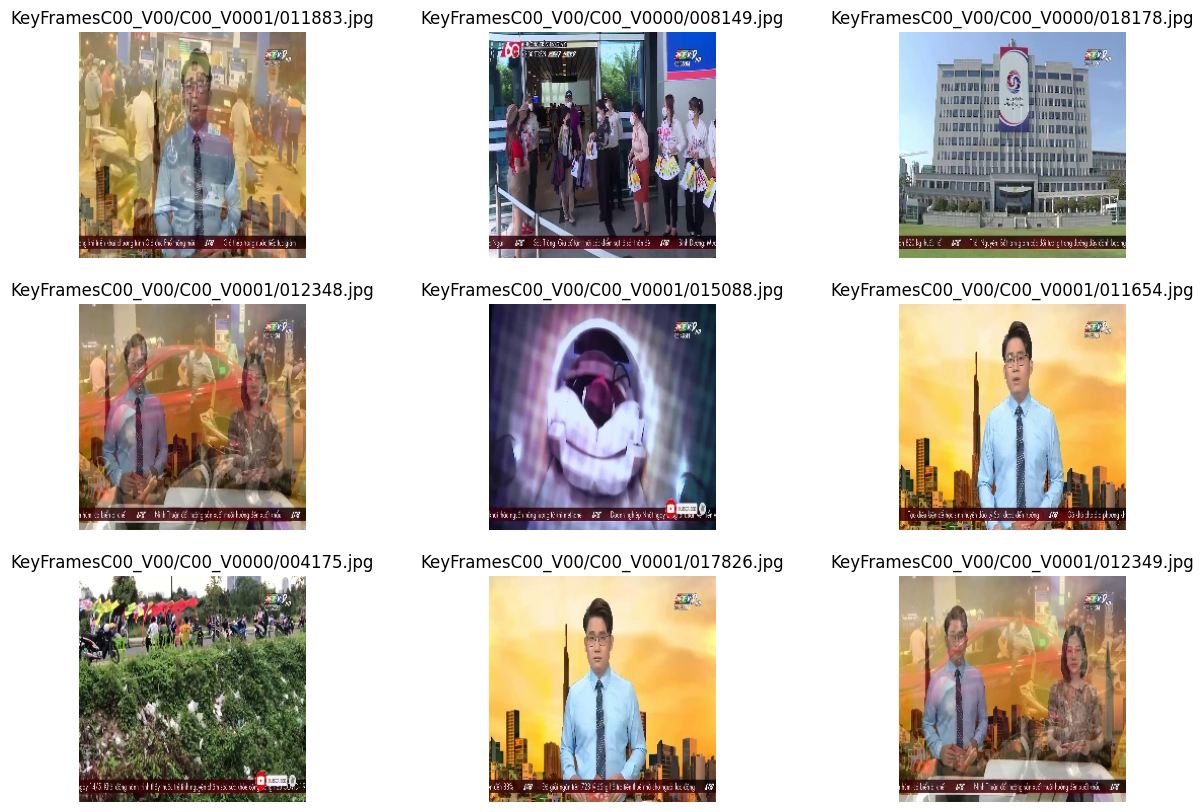

In [14]:
def main():

  ##### TESTING #####
  bin_file='data/faiss_merge_files/faiss_CLIPClient_cosine.bin'
  json_path = 'data/faiss_merge_files/keyframes_id.json'

  cosine_faiss = MyFaiss('./Database', bin_file, json_path)


  ##### TEXT SEARCH #####
  text = 'MC đang dẫn chương'

  
  scores, infos_query, image_paths = cosine_faiss.text_search(text, k=9)
  # cosine_faiss.write_csv(infos_query, des_path_submit='./')
  cosine_faiss.show_images(image_paths)

if __name__ == "__main__":
    main()